## This notebook is for plotting the results of the fake_gal runs on the cluster

In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves

In [2]:
# number of bins in fit
num_bins = 10
name = "NGC2366"
distance = 3400. # [kpc]

# files needed
directory = "/Users/stephencoffey/Downloads/little-things/data"
observed_2d_vel_field_fits_file = f"{directory}/{name}_1mom.fits"
observed_2d_dispersion_fits_file = f"{directory}/{name}_2mom.fits"
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape
ring_param_file = f"{directory}/{name}_ring_parameters_rohit.txt"

# Needed for bin_edges
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)
bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(num_bins)]

In [3]:
save_dir = "/Users/stephencoffey/Downloads/little-things/notebooks/experiments/fake_gal"
from fit2d.analysis.emcee import get_output_files, combine_results_statistics, get_sampler_statistics, plot_walker_paths, plot_posterior_distributions

In [4]:
# params: list of strings ['Velocity','Inclination','Position Angle'] 
# bins_fit: list
# min_iter & max_iter: int
# path: string

from tabulate import tabulate

def plotting(params, bins_fit, min_iter, max_iter, path):
    d = {}
    for i in bins_fit:
        bin_min, bin_max = bin_edges[i], bin_edges[i+1]
        #with open(f'{path}/sampler_{name}_ring{i}_2.39-2.97.pkl', 'rb') as f:
        with open(f'{path}/sampler_{name}_ring{i}_{bin_min:.2f}-{bin_max:.2f}.pkl', 'rb') as f:
            d[f'saved_sampler_{name}_ring{i}'] = joblib.load(f)
            
    # just messing around with the table settings of the tabulate package
    for sampler in d.values():
        stats = list(get_sampler_statistics(sampler, min_iter = max_iter//2, max_iter = max_iter).values())
        lnprob = sampler.get_log_prob()
        table = []
        
        # ACT = sampler.get_autocorr_time()
        
        for i in range(len(stats)):
            mean, std = list(stats[i].values())
            # grabbing the values of the params for the fake galaxy
            if i == 0:
                exp_val = 40.
            else:
                exp_val = np.radians(45)
            if abs(mean-exp_val) <= std:
                within = 'Yes'
            else:
                within = 'No'
                
            # the "\033[1m" bolds the string, the "\033[0m" unbolds formatting for following strings
            table.append([None,"\033[1m" + 'Mean','Std','Within 1-std?'])
            table.append(["\033[1m" + params[i] + "\033[0m",mean,std, within])
        print(tabulate(table, tablefmt = 'fancy_grid'))
      
    for sampler in d.values():   
        walker_paths_figure = plot_walker_paths(
            sampler, 
            param_names = params, 
            min_iter=min_iter, 
            max_iter=max_iter
        )
    for sampler in d.values():
        posterior_distribution_figures = plot_posterior_distributions(
            sampler, 
            min_iter=min_iter, 
            max_iter=max_iter
        )
        


╒════════════════╤════════════════════╤══════════════════════╤═══════════════╕
│                │ Mean               │ Std                  │ Within 1-std? │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Velocity       │ 40.51246969195991  │ 2.2471411316763152   │ Yes           │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│                │ Mean               │ Std                  │ Within 1-std? │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Position Angle │ 0.8229046909733406 │ 0.042198411981742484 │ Yes           │
╘════════════════╧════════════════════╧══════════════════════╧═══════════════╛


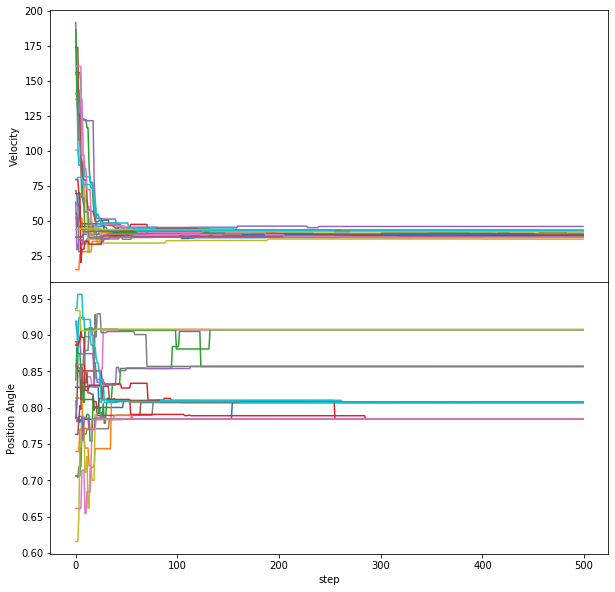

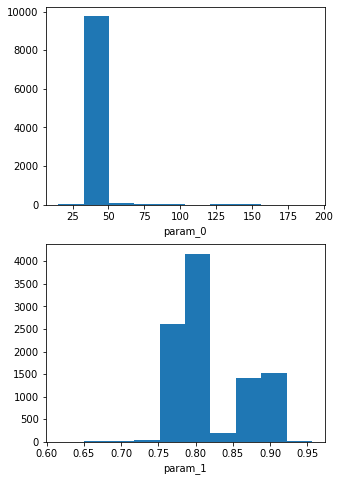

In [5]:
plotting(['Velocity','Position Angle'],[i for i in range(4,5)], 0, 500, f'{save_dir}/pa_1bin_5th')


╒══════════╤═══════════════════╤════════════════════╤═══════════════╕
│          │ Mean              │ Std                │ Within 1-std? │
├──────────┼───────────────────┼────────────────────┼───────────────┤
│ Velocity │ 39.69550218613591 │ 0.7154249521487174 │ Yes           │
╘══════════╧═══════════════════╧════════════════════╧═══════════════╛


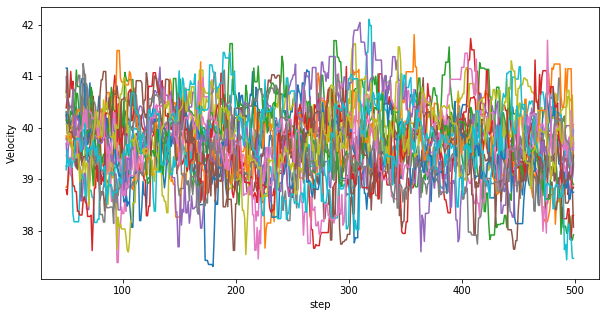

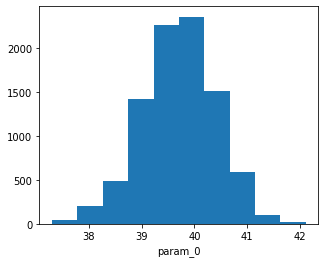

In [13]:
plotting(['Velocity'], [i for i in range(0,1)], 50, 500, f"{save_dir}/vel_1bin_1st")

╒══════════╤═══════════════════╤═══════════════════╤═══════════════╕
│          │ Mean              │ Std               │ Within 1-std? │
├──────────┼───────────────────┼───────────────────┼───────────────┤
│ Velocity │ 40.79931905467819 │ 1.214594334371836 │ Yes           │
╘══════════╧═══════════════════╧═══════════════════╧═══════════════╛


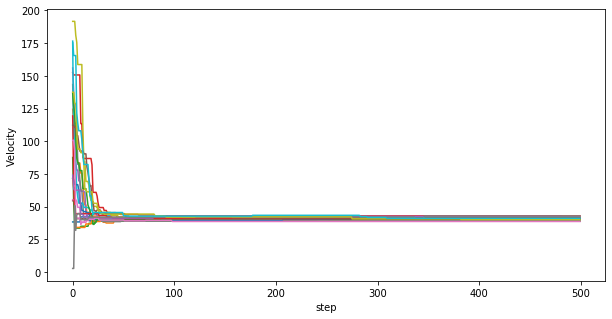

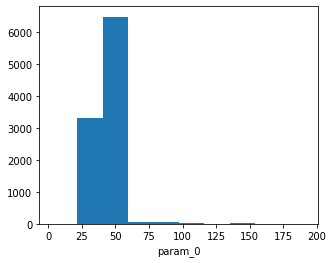

In [24]:
plotting(['Velocity'], [i for i in range(4,5)], 0, 500, f"{save_dir}/vel_1bin_5th")

╒══════════╤════════════════════╤═══════════════════╤═══════════════╕
│          │ Mean               │ Std               │ Within 1-std? │
├──────────┼────────────────────┼───────────────────┼───────────────┤
│ Velocity │ 40.530436876824496 │ 1.336788520487081 │ Yes           │
╘══════════╧════════════════════╧═══════════════════╧═══════════════╛


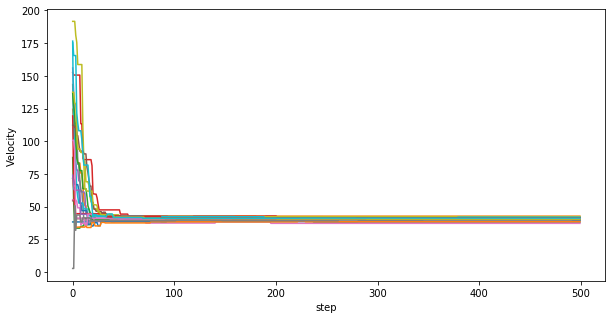

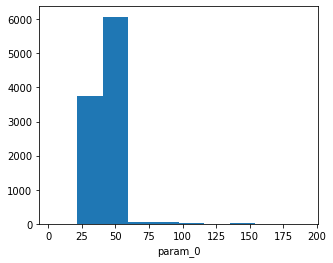

In [23]:
plotting(['Velocity'], [i for i in range(9,10)], 0, 500, f"{save_dir}/vel_1bin_10th")

╒═════════════╤════════════════════╤══════════════════════╤═══════════════╕
│             │ Mean               │ Std                  │ Within 1-std? │
├─────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Velocity    │ 40.33060935880193  │ 1.6809668948981942   │ Yes           │
├─────────────┼────────────────────┼──────────────────────┼───────────────┤
│             │ Mean               │ Std                  │ Within 1-std? │
├─────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Inclination │ 0.8049665594983436 │ 0.034489800812434794 │ Yes           │
╘═════════════╧════════════════════╧══════════════════════╧═══════════════╛


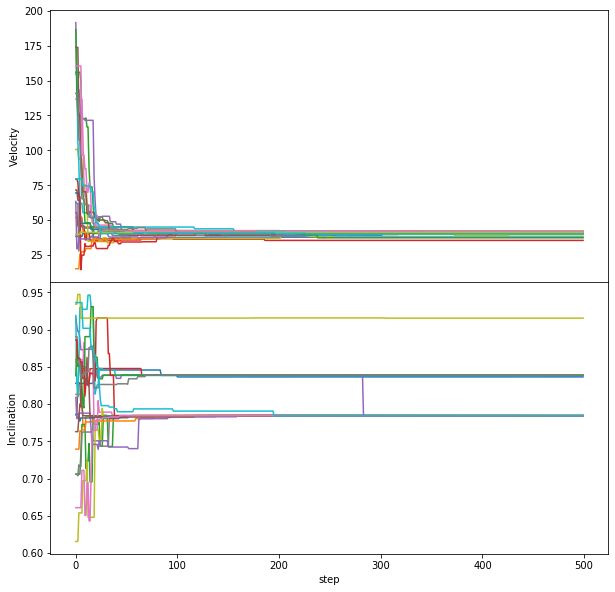

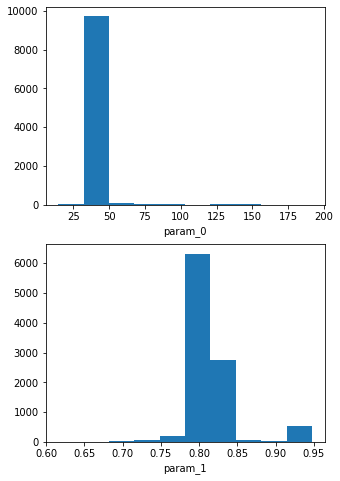

In [22]:
plotting(['Velocity','Inclination'], [i for i in range(4,5)], 0, 500, f"{save_dir}/inc_1bin_5th")

╒════════════════╤════════════════════╤══════════════════════╤═══════════════╕
│                │ Mean               │ Std                  │ Within 1-std? │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Velocity       │ 41.74901671332973  │ 3.288124429736159    │ Yes           │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│                │ Mean               │ Std                  │ Within 1-std? │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Inclination    │ 0.7900070690172953 │ 0.05373783310639119  │ Yes           │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│                │ Mean               │ Std                  │ Within 1-std? │
├────────────────┼────────────────────┼──────────────────────┼───────────────┤
│ Position Angle │ 0.7587974725960134 │ 0.055047357952522115 │ Yes           │
╘════════════════╧════════════════════╧═════════════

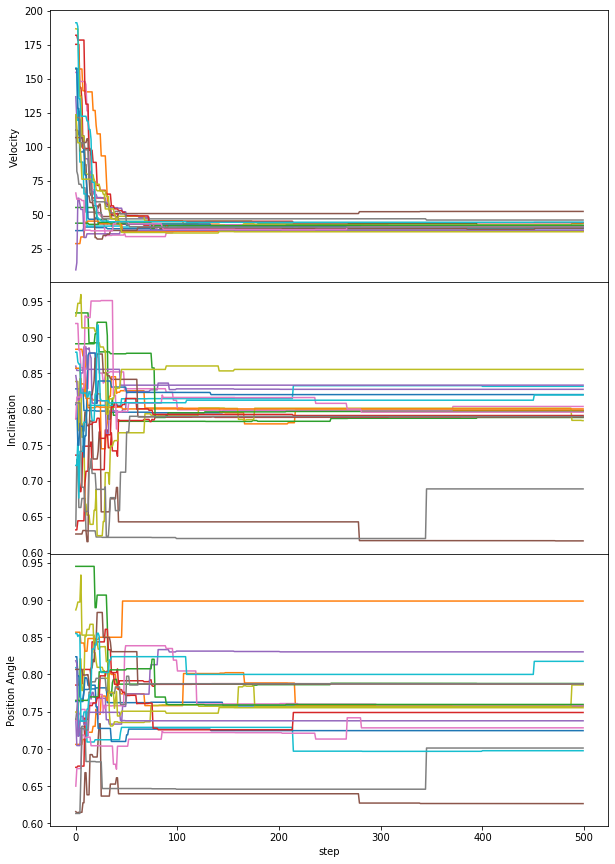

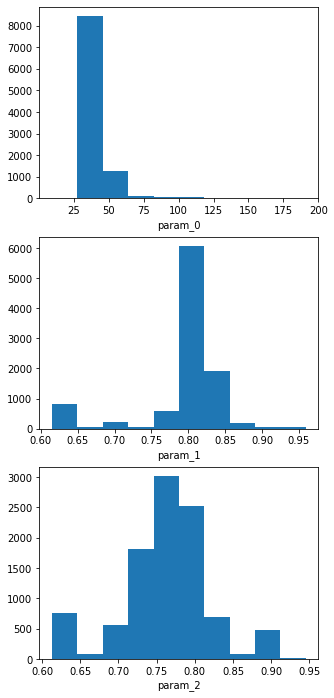

In [21]:
plotting(['Velocity','Inclination','Position Angle'], [i for i in range(4,5)], 0, 500, f"{save_dir}/inc+pa_1bin_5th")

╒════════════════╤════════════════════╤═════════════════════╤═══════════════╕
│                │ Mean               │ Std                 │ Within 1-std? │
├────────────────┼────────────────────┼─────────────────────┼───────────────┤
│ Velocity       │ 40.71083518700968  │ 3.0794105953787163  │ Yes           │
├────────────────┼────────────────────┼─────────────────────┼───────────────┤
│                │ Mean               │ Std                 │ Within 1-std? │
├────────────────┼────────────────────┼─────────────────────┼───────────────┤
│ Inclination    │ 0.8639445995718347 │ 0.06536028016046831 │ No            │
├────────────────┼────────────────────┼─────────────────────┼───────────────┤
│                │ Mean               │ Std                 │ Within 1-std? │
├────────────────┼────────────────────┼─────────────────────┼───────────────┤
│ Position Angle │ 0.7415797910232934 │ 0.06390565274452602 │ Yes           │
╘════════════════╧════════════════════╧═════════════════════╧═══

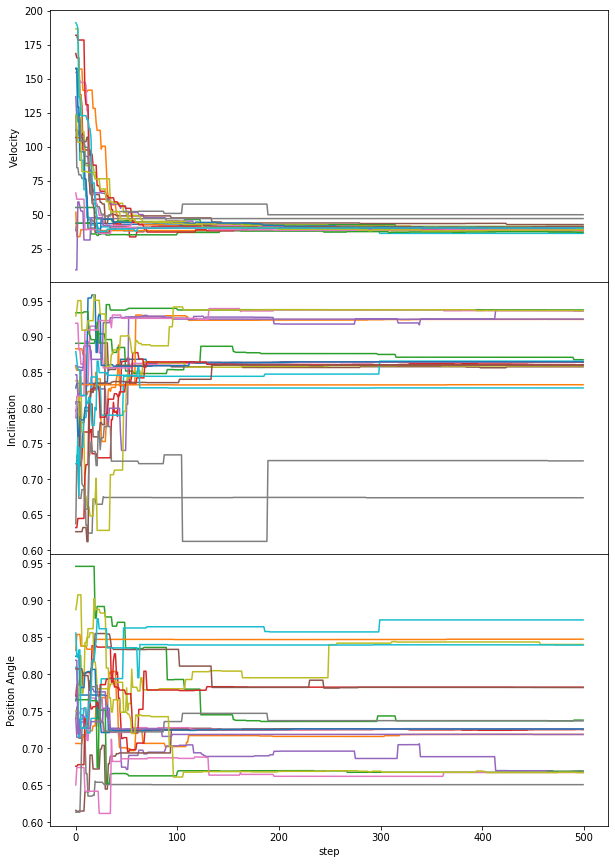

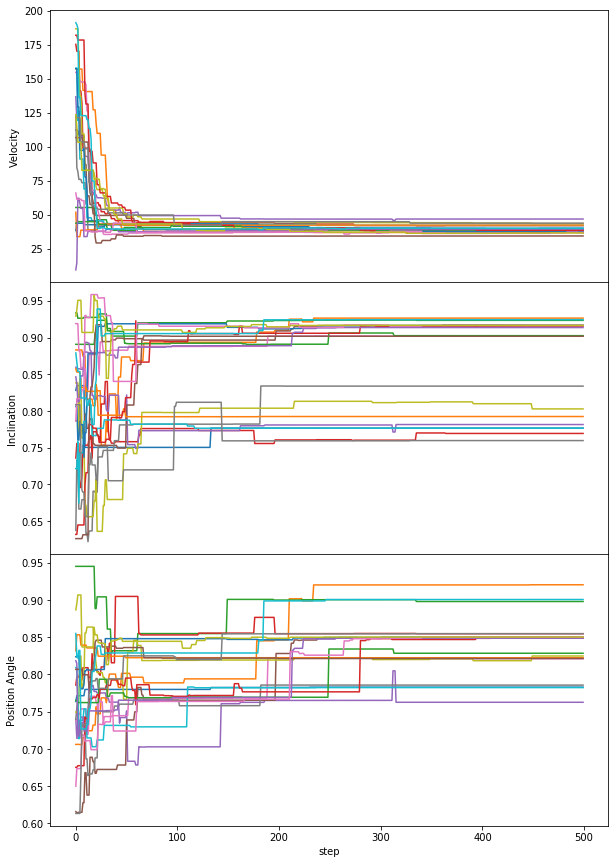

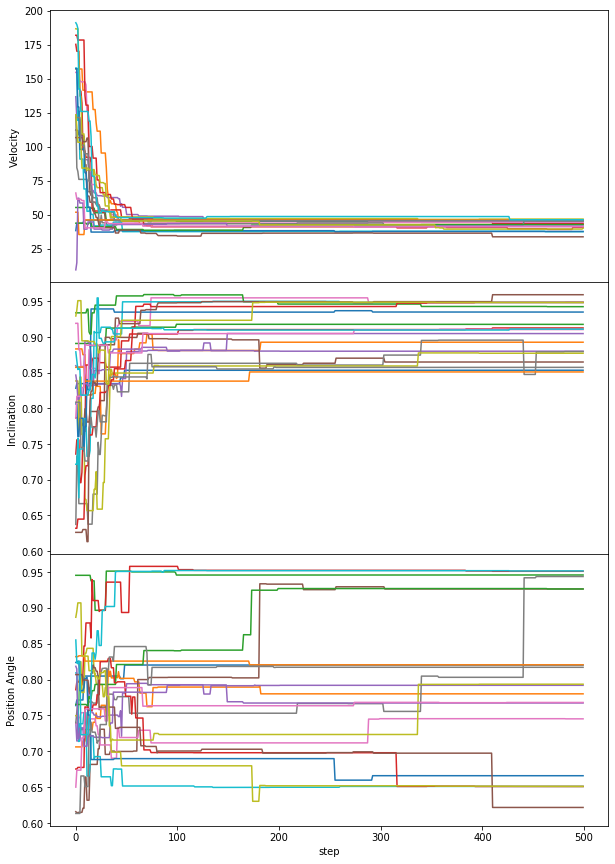

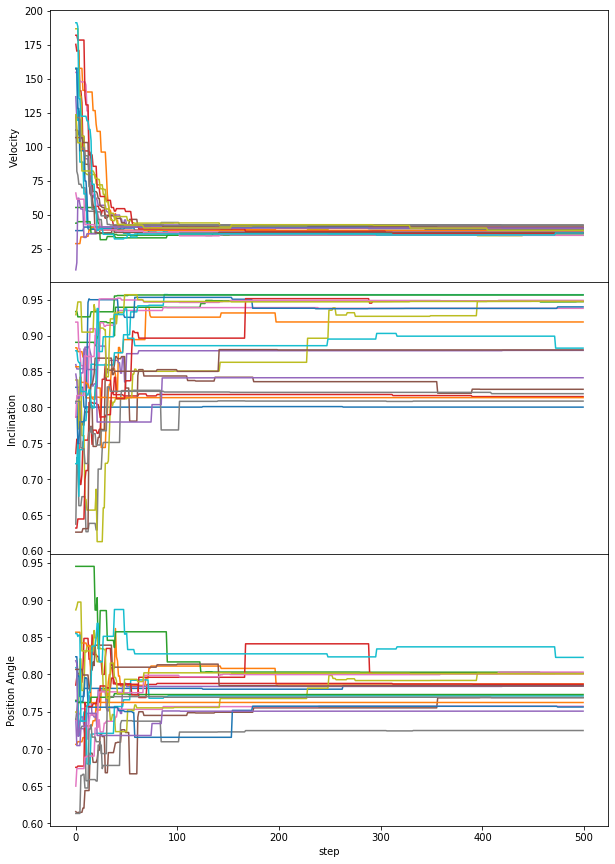

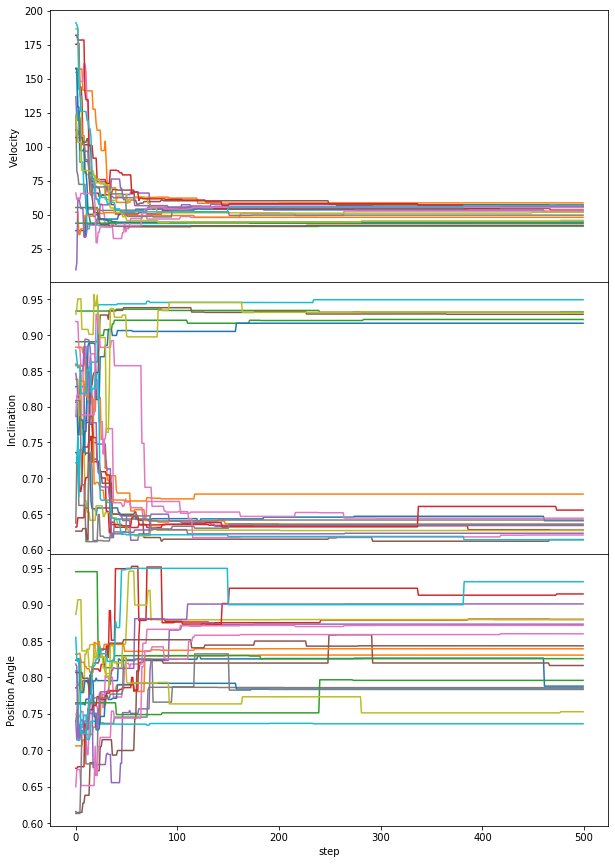

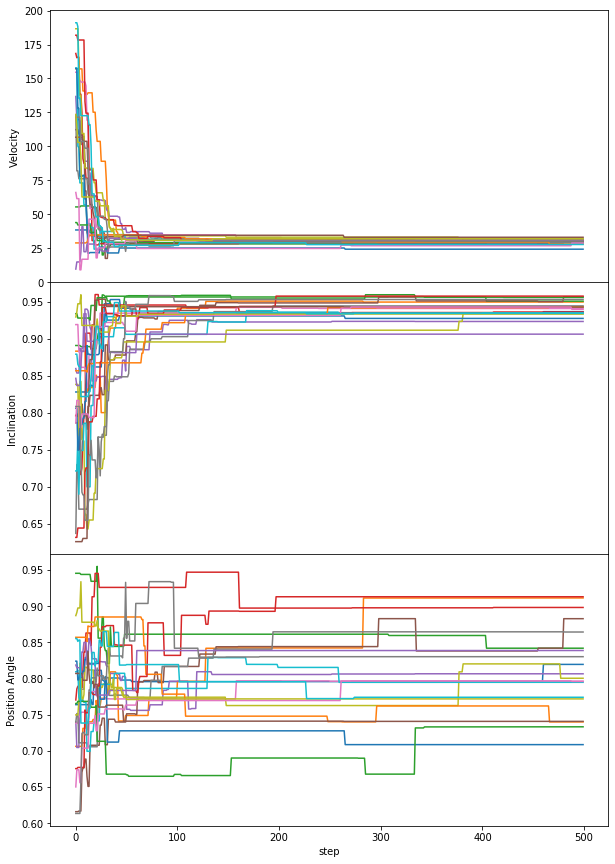

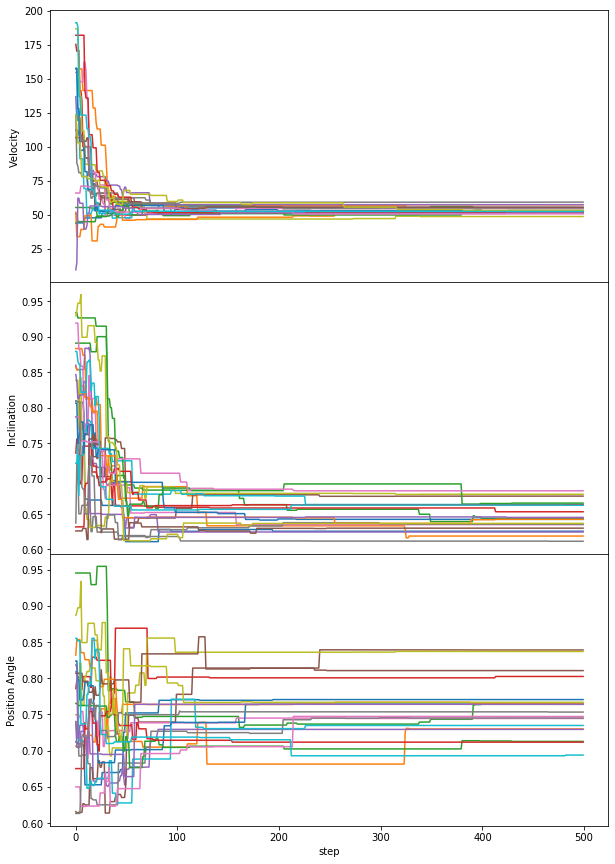

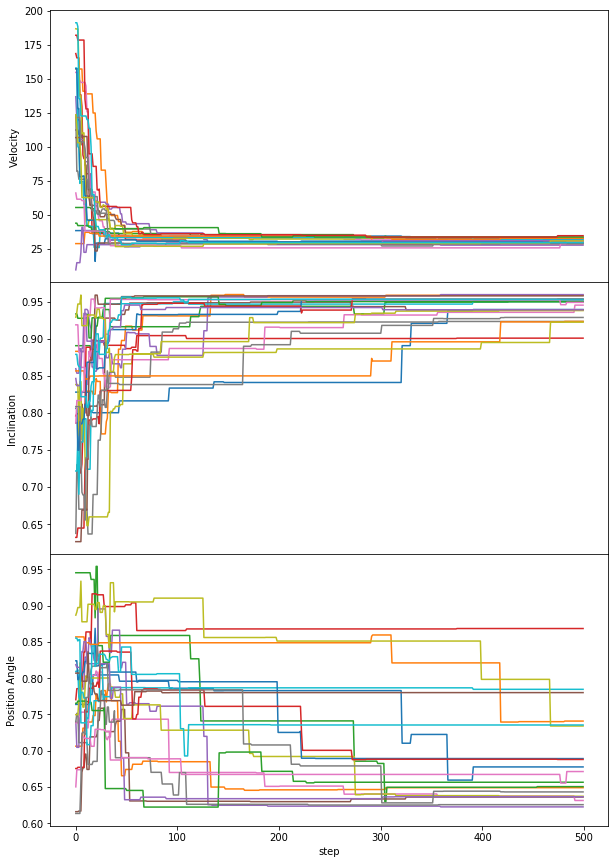

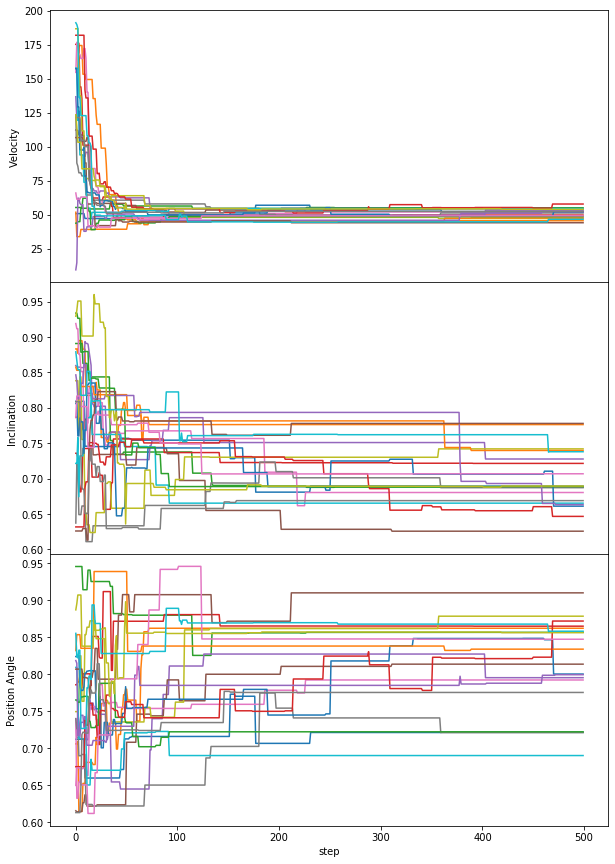

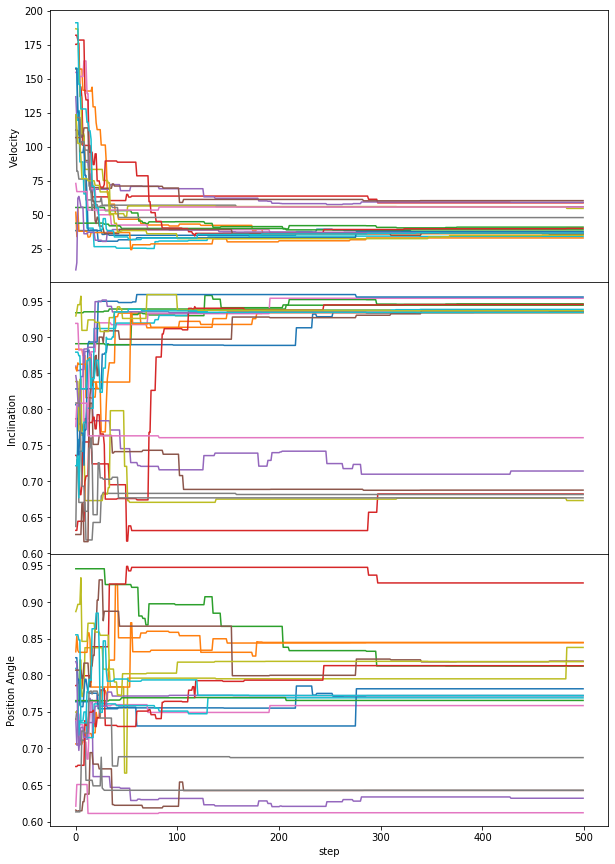

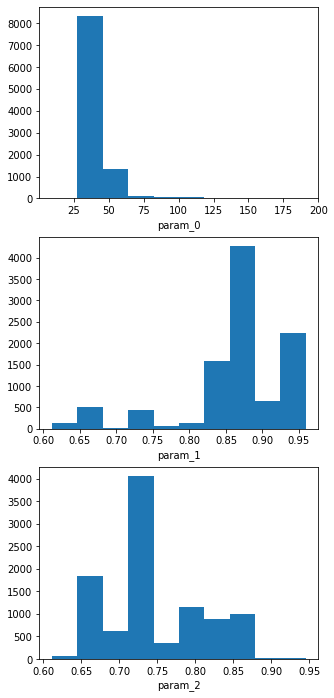

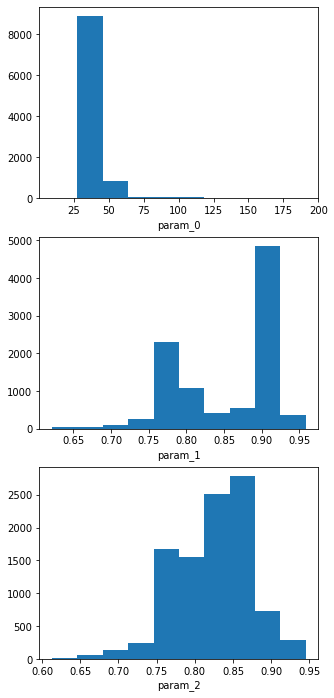

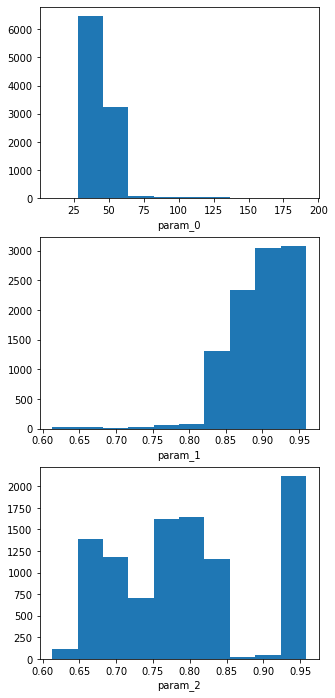

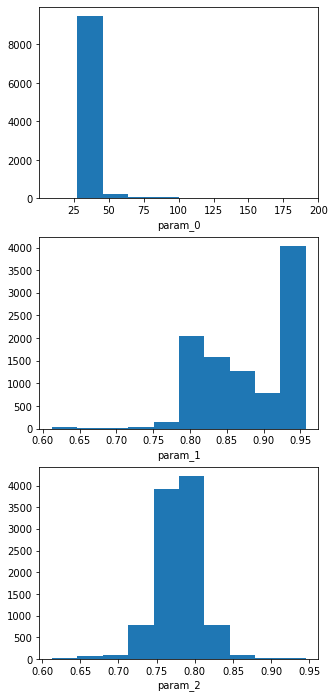

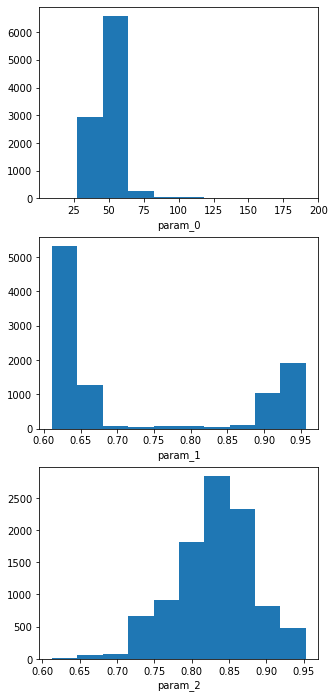

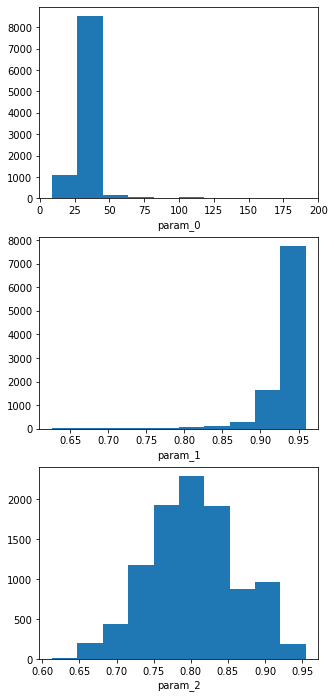

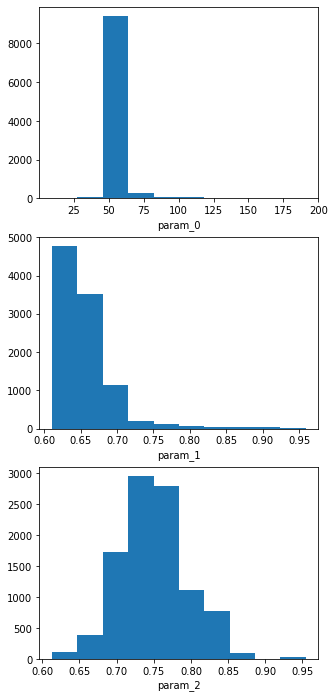

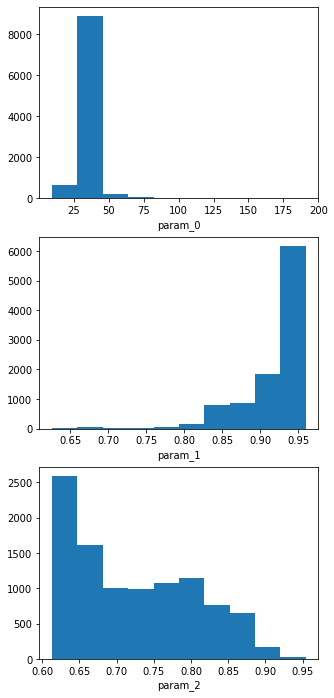

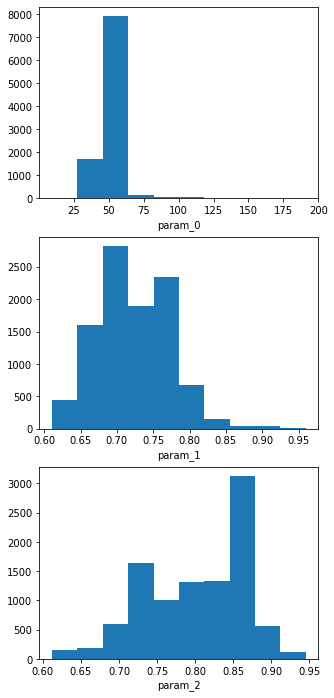

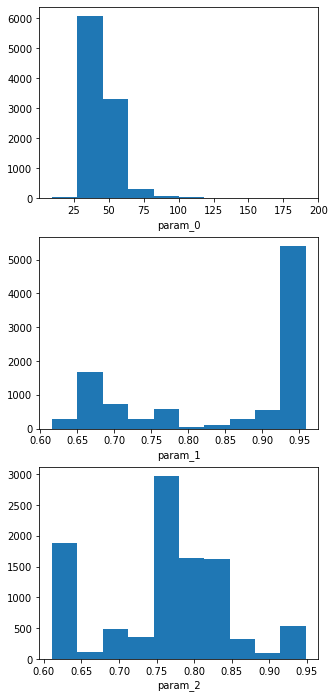

In [20]:
plotting(['Velocity','Inclination','Position Angle'], [i for i in range(10)], 0, 500, f"{save_dir}/inc+pa_10bins")